This notebook serves as a tutorial to guide users apply `Scouter` to their own datasets. The dataset in this notebook as an example is the [Adamson](https://www.sciencedirect.com/science/article/pii/S0092867416316609) dataset, including 86 one-gene perturbations generated using Perturb-seq.

# 1. Data Setup

In [1]:
import pickle
import torch
import anndata as ad
import pandas as pd
import numpy as np
import random
from scouter import Scouter, ScouterData

Please provide the following file paths:
- `embd_path`: the path of the LLM embeddings generated from each gene's text description
- `data_path`: the path of the dataset that include gene expression for both perturbed and control cells, in the form of `.h5ad`

#### To use your own customized data. Please make sure to do the following quality controls:
- Well annotated each cell's perturbation group and stored them in `.obs`
- The embedding matrix index must be consistent with the perbutation annoation. In other words, If perturbed genes are annotated using gene symbols, the embedding matrix index must also use gene symbols to ensure consistency.
- Remove the inefficiently perturbed cells. For example, removing the cells whose knock-outed gene's expression is still similarly high as control cells.

In [2]:
data_path = '/Users/liuyi/AA_Scouter/data/norman/perturb_processed.h5ad'
embd_path = '/Users/liuyi/Desktop/GenePT_emebdding_v2/GenePT_gene_embedding_ada_text.pickle'

In [3]:
def set_seeds(seed=24):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        
# Normalize the condition name. Make "A+B" and "B+A" the same
def condition_sort(x):
    return '+'.join(sorted(x.split('+')))

# Set seeds for reproducibility
set_seeds(24)

### a) Load `.h5ad` scRNA-seq file as Anndata

In [4]:
adata = ad.read_h5ad(data_path)
adata.obs['condition'] = adata.obs['condition'].astype(str).apply(lambda x: condition_sort(x)).astype('category')
adata.uns = {}; adata.obs.drop('condition_name', axis=1, inplace=True)
print(adata)

AnnData object with n_obs × n_vars = 91205 × 5045
    obs: 'condition', 'cell_type', 'dose_val', 'control'
    var: 'gene_name'
    layers: 'counts'


In [5]:
# check the number of cells under each genetic perturbation
print(adata.obs.condition.value_counts())

condition
ctrl             7353
KLF1+ctrl        1641
BAK1+ctrl        1171
CEBPE+ctrl       1039
ETS2+ctrl        1031
                 ... 
PLK4+STIL          66
SAMD1+TGFBR2       59
CEBPB+JUN          52
CBL+UBASH3A        50
C3orf72+FOXL2      49
Name: count, Length: 237, dtype: int64


### b) Load the gene embedding matrix as as a `pandas.DataFrame`

In order to make `Scouter` aware of that `'GeneA+ctrl'` denotes a one-gene perturbation but `'GeneA+GeneB'` denotes a two-gene perturbation, please add a row of zeros for `'ctrl'` to the embedding dataframe.
\
\
**Note: it is possible that there exist some perturbed genes not presented in your provided embedding dataframe. However:**
- theoratically, as long as there is text description for that gene, you can always obtain embeddings for it.
- this unmatch might due to the different gene symbols for the actually same gene. See details in the notebook of [UnmatchRemedy](UnmatchRemedy.ipynb).

In [6]:
with open(embd_path, 'rb') as f:
    embd = pd.DataFrame(pickle.load(f)).T
ctrl_row = pd.DataFrame([np.zeros(embd.shape[1])], columns=embd.columns, index=['ctrl'])
embd = pd.concat([ctrl_row, embd])
embd

,0,1,2,3,4,5,6,7,8,9,...,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535
ctrl,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A1BG,-0.043067,-0.020245,-0.002102,-0.017412,-0.004772,0.018790,-0.014167,0.031064,-0.031476,-0.015532,...,0.017876,0.011861,0.018005,-0.022229,-0.010683,0.012982,-0.017103,-0.046699,-0.006304,0.005322
A1BG-AS1,-0.027003,-0.006847,0.007299,-0.025647,-0.014492,0.028187,-0.025594,0.015941,-0.013449,-0.011075,...,0.005185,-0.005292,0.023267,-0.001981,-0.007359,0.017417,-0.014718,-0.044753,-0.007658,-0.001966
A1CF,-0.040730,-0.014075,0.006621,-0.016098,-0.014863,0.028676,-0.013485,0.035556,-0.019065,-0.008430,...,0.016544,0.017621,-0.017489,-0.015796,-0.027547,0.031906,-0.001667,-0.029385,-0.015073,-0.006473
A2M,-0.029095,-0.001240,-0.015252,-0.025177,-0.012216,0.018987,-0.026927,0.009624,-0.008991,0.006676,...,0.029121,-0.007874,0.013072,-0.018191,-0.007998,0.017277,0.000805,-0.049257,0.005132,0.001392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KRTAP28p1,-0.023102,-0.027802,0.012746,-0.025011,-0.025319,0.011838,-0.012279,0.012532,-0.002612,-0.001223,...,0.021593,0.001784,-0.006917,-0.015584,-0.016211,0.015237,-0.004383,-0.029992,-0.011564,-0.028737
ELOC26,-0.018420,-0.001902,0.016638,-0.047502,-0.040348,0.031001,-0.014815,0.021983,-0.009484,0.016926,...,-0.009923,-0.017529,-0.000795,-0.000451,-0.016761,0.033331,-0.005880,-0.003310,0.013431,-0.021874
FASRL,-0.020013,-0.018781,0.006378,-0.025457,-0.029833,0.016620,-0.011967,0.019238,-0.029445,0.005222,...,0.003350,0.005149,0.013137,-0.017991,-0.004148,0.010685,-0.019307,-0.018268,-0.019376,-0.017714
COMT2,-0.021027,-0.005336,-0.008690,-0.036186,-0.029208,0.038274,-0.008141,0.021674,-0.031666,0.009516,...,0.014181,0.013824,-0.018714,-0.005782,-0.021146,0.024820,0.002504,-0.003615,-0.014974,-0.036582


# 2. Data Loader

`ScouterData` is a dataloader that combiens the gene expression and gene embeddigns together, and prepares the training of `Scouter`. The function takes as input:
- `adata`: the adata object that contains gene expression and cell annotations
- `embd`: the dataframe that contains ge
- `key_label`: The column name of `adata.obs` that corresponds to perturbation conditions
- `key_var_genename`: The column name of `adata.var` that corresponds to gene names. This is for readability of plots later, where you can show genes in their names instead of index or ensembl ids.

In [7]:
scouterdata = ScouterData(adata=adata, embd=embd, key_label='condition', key_var_genename='gene_name')

We perform the follwing necessary preprocessing for the smooth training of `Scouter` later:
- `ScouterData.setup_ad(key_embd_index)`: Setup `adata` and `embd`.
        `embd` will be filtered so that it only contains the matched genes to save memory usage.
        `adata` will drop the perturbation conditions not covered by matched genes.
        A new column named `key_embd_index` will be added to `adata.obs`, denoting the index of perturbed genes in `embd`.

- `ScouterData.gene_ranks()`: Rank genes for each perturbation group. Saved as a dictionary in `adata.uns['rank_genes_groups']`. We need this step for model measurement, because we only calculate the metric across top20 DEGs.

- `ScouterData.get_dropout_non_zero_genes()`: Compute the non-zero genes and top 20 differentially expressed genes for each perturbation group. We perform this step because in the loss function of `Scouter`, we only calculate the loss on non-zeros of each group.

- `ScouterData.split_Train_Val_Test(seed)`: split the data into three sets: Training, Validation, and Testing, based on the random seed `seed`.

In [8]:
scouterdata.setup_ad('embd_index')
scouterdata.gene_ranks()
scouterdata.generate_labels(log2fc_threshold=1.0, fdr_threshold=0.05)
scouterdata.split_Train_Val_Test(seed=1)

2 perturbed genes are not found in the gene embedding matrix: 
['KIAA1804' 'RHOXF2BB']. 
Hence they are deleted. Please check if this is because of different gene synonyms. 
Please check if the deletion of following conditions are correct: 
['KIAA1804+ctrl', 'RHOXF2BB+SET', 'RHOXF2BB+ZBTB25', 'RHOXF2BB+ctrl']


### So far, loading the user's own dataset is finished. The following training, prediction, and evaluation steps are same as those in [Demo](Demo.ipynb).

# 3. `Scouter` Training

We train `Scouter` model on `scouterdata`. This is a supervised training, so we would recommend a hyperparameter searching based on the metrics on validation set for both `Scouter.model_init()` and `Scouter.train()`. However, across the experiments on five different datasets in our work, we notice most hyparameters are not sensitive. Therefore, users are welcome to start with our default parameters. For a efficient searching, we recommend targeting on these parameters:
- `loss_gamma` in `Scouter.train()`: $\gamma$ in $L_\text{autofocus}$. `loss_gamma=0` denotes MSE loss. `loss_gamma=0` returns the best result on all five datasets in our work.
- `loss_lambda` in `Scouter.train()`: $\lambda$ in $L=L_\text{autofocus}+\lambda L_\text{direnction}$
- `lr` in `Scouter.train()`: learning rate
- gene embedding source: In this example, we use the embeddings provided by [GenePT](https://github.com/yiqunchen/GenePT). However, there are some other embeddings available online. The author of [scELMo](https://sites.google.com/yale.edu/scelmolib) collected a series of embeddings for biological terms.

In [9]:
# Calculate class weights to handle imbalance
labels = scouterdata.train_adata.varm['labels'].values.flatten()
class_counts = np.bincount(labels + 1)
class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float32)
class_weights = class_weights / class_weights.sum()

In [14]:
scouter_model = Scouter(scouterdata)
scouter_model.model_init()
scouter_model.train(alpha=class_weights, gamma=2)

Epoch 1/40 - Validation Batches: 100%|██████████| 24/24 [00:01<00:00, 22.91batch/s]


Epoch 1/40, Training Loss: 0.0049, Validation Loss: 0.0061


Epoch 2/40 - Validation Batches: 100%|██████████| 24/24 [00:00<00:00, 24.03batch/s]


Epoch 2/40, Training Loss: 0.0024, Validation Loss: 0.0028


Epoch 3/40 - Validation Batches: 100%|██████████| 24/24 [00:01<00:00, 23.24batch/s]


Epoch 3/40, Training Loss: 0.0015, Validation Loss: 0.0031


Epoch 4/40 - Validation Batches: 100%|██████████| 24/24 [00:01<00:00, 23.89batch/s]


Epoch 4/40, Training Loss: 0.0015, Validation Loss: 0.0024


Epoch 5/40 - Validation Batches: 100%|██████████| 24/24 [00:01<00:00, 22.36batch/s]


Epoch 5/40, Training Loss: 0.0012, Validation Loss: 0.0023


Epoch 6/40 - Validation Batches: 100%|██████████| 24/24 [00:01<00:00, 23.69batch/s]


Epoch 6/40, Training Loss: 0.0013, Validation Loss: 0.0023


Epoch 7/40 - Validation Batches: 100%|██████████| 24/24 [00:00<00:00, 24.08batch/s]

Epoch 7/40, Training Loss: 0.0013, Validation Loss: 0.0023
Early stopping after 7 epochs


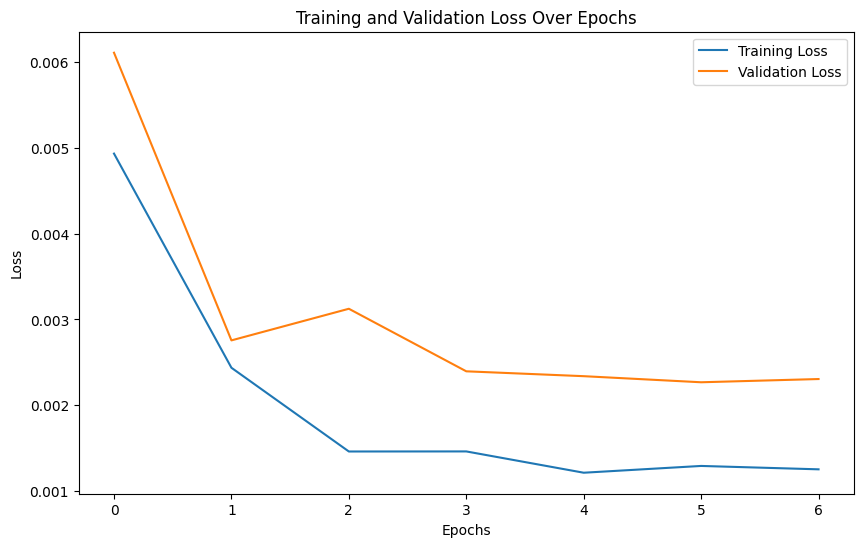

In [15]:
import matplotlib.pyplot as plt
loss_history = scouter_model.loss_history
plt.figure(figsize=(10, 6))
plt.plot(loss_history['train_loss'], label='Training Loss')
plt.plot(loss_history['val_loss'], label='Validation Loss')

plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 4. Model Prediction

To make predictions on specific gene perturbations, we can use `Scouter.pred` with parameters:
- `pert_list`: a list of perturation names for prediction
- `n_pred`: how many control cells sampled to make the prediction. The resulting prediciton matrix for each perturbation would have shape of `[n_pred, n_genes]`
- `seed`: reproduce the prediction result by setting a seed.

In [16]:
pred_dict = scouter_model.pred(['KLF1+ctrl', 'BAK1+ctrl'])
pred_dict['KLF1+ctrl'].shape
pred_dict['KLF1+ctrl']

array([[0.03626004, 0.9278753 , 0.0358647 ],
       [0.03567337, 0.9300671 , 0.03425946],
       [0.00544322, 0.5140142 , 0.4805426 ],
       ...,
       [0.4056191 , 0.5807819 , 0.01359906],
       [0.03453162, 0.92791116, 0.03755718],
       [0.03299948, 0.9289685 , 0.03803198]],
      shape=(5045, 3), dtype=float32)

# 5. Model Evaluation

In [17]:
metric_df = scouter_model.evaluate()
metric_df

,Perturbation,Accuracy,Precision,Recall,F1-score,Confusion matrix
0,TSC22D1+ctrl,0.824579,0.334367,0.497113,0.303362,"[[0, 0, 0], [241, 4158, 643], [1, 0, 2]]"
1,CEBPE+ctrl,0.859663,0.462422,0.800831,0.512035,"[[27, 0, 10], [199, 4127, 456], [15, 28, 183]]"
2,PTPN12+UBASH3B,0.838454,0.403029,0.795164,0.423545,"[[37, 0, 12], [190, 4159, 604], [9, 0, 34]]"
3,KLF1+ctrl,0.828741,0.355349,0.604520,0.344538,"[[8, 0, 10], [219, 4151, 616], [15, 4, 22]]"
4,IKZF3+MAP2K6,0.835481,0.378726,0.833551,0.387460,"[[18, 0, 2], [206, 4158, 610], [12, 0, 39]]"
5,TBX2+TBX3,0.834093,0.381111,0.761793,0.388995,"[[23, 0, 13], [207, 4155, 610], [5, 2, 30]]"
6,RREB1+ctrl,0.827354,0.343020,0.784958,0.320897,"[[4, 0, 1], [234, 4162, 633], [3, 0, 8]]"
7,DUSP9+MAPK1,0.828147,0.351279,0.898142,0.336772,"[[8, 0, 0], [226, 4157, 639], [2, 0, 13]]"
8,COL2A1+ctrl,0.835084,0.376437,0.732151,0.383618,"[[17, 0, 6], [210, 4157, 592], [15, 9, 39]]"
9,ZBTB25+ctrl,0.826957,0.343192,0.624473,0.320926,"[[6, 0, 5], [232, 4163, 633], [3, 0, 3]]"
